# Data Exploration

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df = pd.read_csv('DataAnalyst.csv')

In [31]:
# drop the first column
def data_cleaning(df):
    df.drop(df.columns[0], axis=1, inplace=True)
    df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.split('(')[0])
    df.fillna("Not Available", inplace=True)
    df["Company Name"] = df["Company Name"].apply(lambda x: x.split('\n')[0])
    df["Size"] = df["Size"].apply(lambda x: x.split('employees')[0])
    df["Size"] = df["Size"].apply(lambda x: x.replace(" to ", "-"))
    return df

df = data_cleaning(df)

In [37]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K,Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201-500,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,Quality Data Analyst,$37K-$66K,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K,We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001-5000,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,Data Analyst,$37K-$66K,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,"New York, NY","McLean, VA",201-500,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,Reporting Data Analyst,$37K-$66K,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,"New York, NY","New York, NY",501-1000,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [52]:
def get_state(x):
    # if there are more than 1 commas in the string, then the state is the 2nd last element
    if x.count(',') > 1:
        return x.split(',')[2]
    else:
        return x.split(',')[1]
    
df['State'] = df['Location'].apply(get_state)


In [73]:
def get_salary_range(x):
    if x == '-1':
        return [-1, -1]
    range_salary = x.split('-')
    n1 = range_salary[0].replace('$', '').replace('K', '').replace(' ', '')
    n2 = range_salary[1].replace('$', '').replace('K', '').replace(' ', '')
    
    range_salary = range(int(n1), int(n2))

    # divide the ranges into 5 groups
    

    return range_salary

[get_salary_range(x) for x in df['Salary Estimate']]

[range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(37, 66),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(46, 87),
 range(51, 88),
 range(51, 88),
 range(5

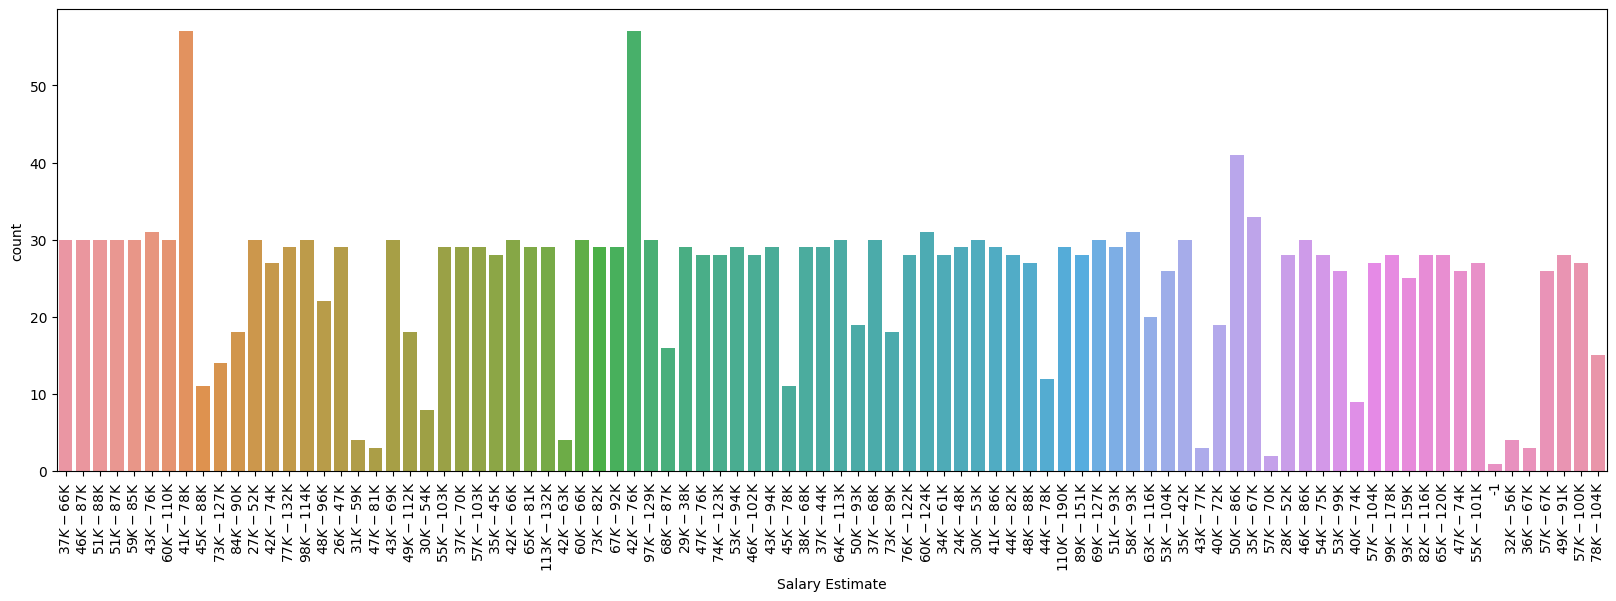

In [35]:
# plot the count of headquarters
def plot_count(df, col):
    plt.figure(figsize=(20, 6))
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=90)
    plt.show()

plot_count(df, "Salary Estimate")